# Import Necessary Library

In [1]:
import os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OneHotEncoder
)

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.transformation import (
    LogTransformer,
    LogCpTransformer,
    YeoJohnsonTransformer
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import (
    KFold, 
    cross_val_score, 
    StratifiedKFold,
    train_test_split,
    RandomizedSearchCV
)

from sklearn.linear_model import (
    LinearRegression, 
    Lasso, 
    Ridge
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score
)

# import preprocessing from prep
# this module is for binning years
import prep as pp

# Data Understanding.

In [2]:
# dataset path
filename = "datasets/preprocessed/data_daegu_apartment.csv"

# load data
df = pd.read_csv(filename)

In [3]:
# top 5 of data
df.head()

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
0,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1387,346017
1,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,5.0,1.0,0.0,1986,4,914,150442
2,mixed,15min~20min,Chil-sung-market,1.0,7.0,3.0,56.0,1997,5,558,61946
3,mixed,5min~10min,Bangoge,5.0,5.0,4.0,798.0,2005,7,914,165486
4,terraced,0-5min,Sin-nam,0.0,1.0,2.0,536.0,2006,5,1743,311504


In [4]:
# shape of data
df.shape

(4123, 11)

In [5]:
# basic information about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   HallwayType                       4123 non-null   object 
 1   TimeToSubway                      4123 non-null   object 
 2   SubwayStation                     4123 non-null   object 
 3   N_FacilitiesNearBy(ETC)           4123 non-null   float64
 4   N_FacilitiesNearBy(PublicOffice)  4123 non-null   float64
 5   N_SchoolNearBy(University)        4123 non-null   float64
 6   N_Parkinglot(Basement)            4123 non-null   float64
 7   YearBuilt                         4123 non-null   int64  
 8   N_FacilitiesInApt                 4123 non-null   int64  
 9   Size(sqf)                         4123 non-null   int64  
 10  SalePrice                         4123 non-null   int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 354.4+ KB


## Feature Information

* **HallwayType** : Apartment Entrance Room Type.
* **TimeToSubway** : Time Required from Apartment to Subway Station (Categorical).
* **SubwayStation** : Underground station name near Apartment.
* **N_FacilitiesNearBy(ETC)** : Number of public facilities near apartments such as hotels and special schools.
* **N_FacilitiesNearBy(PublicOffice)** : Number of Public Offices Near the Apartment.
* **N_SchoolNearBy(University)** : Number of University Near the Apartment.
* **N_Parkinglot(Basement)** : Number of parking spaces in the basement.
* **YearBuilt** 
* **N_FacilitiesInApt** : The number of facilities for residents, such as swimming pools, gyms, and playgrounds.
* **Size(sqf)** : Apartment Size in Square Feet.
* **SalePrice** : Price in US$ (target).

## Check Duplicate

In [6]:
# check data duplicate 
print("Number of duplicate : ", df.duplicated(keep = "first").sum())

# remove duplicate data
df.drop_duplicates(keep = "first", inplace = True)

Number of duplicate :  1422


## Check Descriptive Statistics

In [7]:
# Numerical Columns
display(df.describe())

# Categorical Columns
display(df.describe(include = "O"))

,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
count,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000
mean,1.890411,4.027027,2.680489,533.746390,2002.358386,5.713439,984.028878,229511.365790
std,2.153168,1.887486,1.504470,418.224859,9.151949,2.386552,391.982619,105079.891321
min,0.000000,0.000000,0.000000,0.000000,1978.000000,1.000000,135.000000,32743.000000
25%,0.000000,3.000000,2.000000,181.000000,1993.000000,4.000000,743.000000,153539.000000
50%,1.000000,4.000000,2.000000,536.000000,2006.000000,5.000000,910.000000,221238.000000
75%,5.000000,5.000000,4.000000,798.000000,2007.000000,7.000000,1167.000000,300884.000000
max,5.000000,7.000000,5.000000,1321.000000,2015.000000,10.000000,2337.000000,585840.000000


,HallwayType,TimeToSubway,SubwayStation
count,2701,2701,2701
unique,3,5,8
top,terraced,0-5min,Myung-duk
freq,1667,1248,709


# Exploratory Data Analysis

In [8]:
# split numerical and categorical

num_vars = [col for col in df.columns if df[col].dtypes != "O"]
cat_vars = [col for col in df.columns if df[col].dtypes == "O"]

## Univariate

### Numercial Category

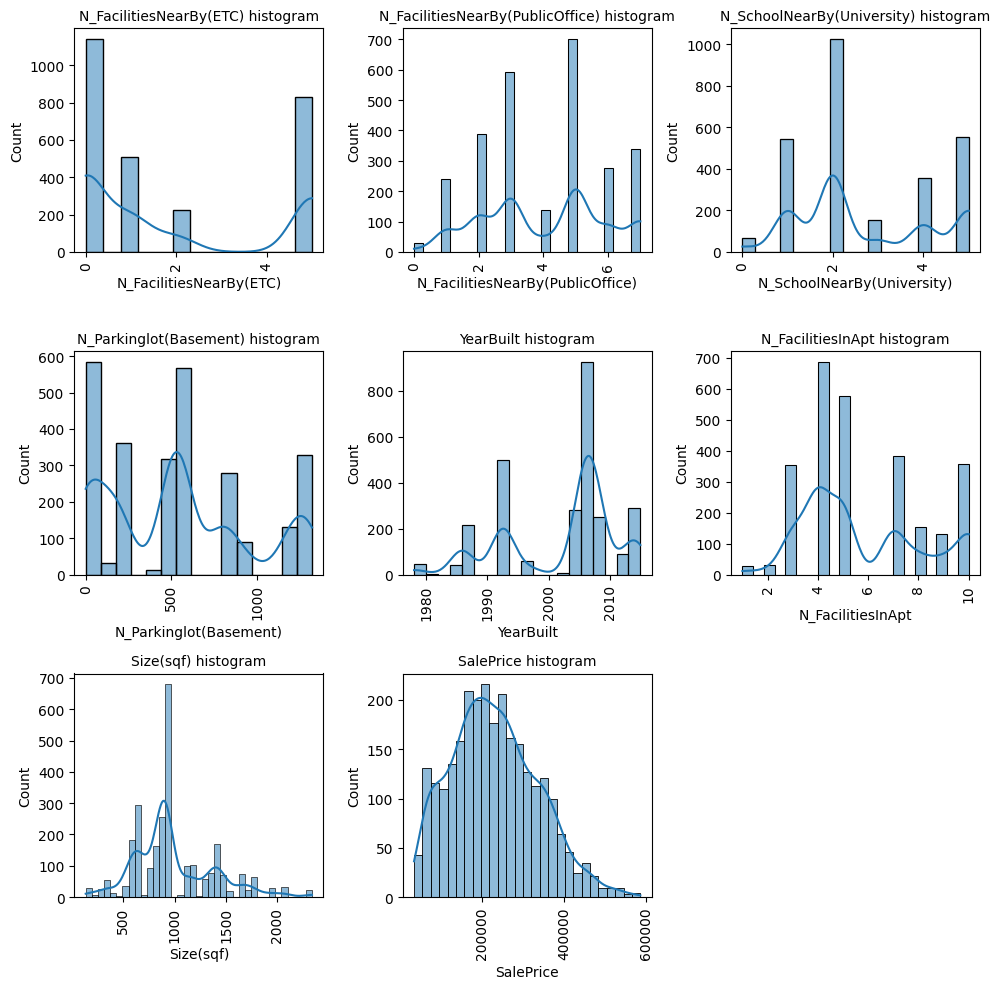

In [9]:
# plot histogram of numerical value

plt.figure(figsize=(10, 10))
for i, var in enumerate(num_vars):
    plt.subplot(3, 3, i+1)
    plt.title(f"{var} histogram", fontsize=10)
    sns.histplot(data=df, x=var, kde=True)
    plt.xticks(rotation=90)
    plt.tight_layout()

plt.savefig("assets/numerical_histogram.png")
plt.show()

### Category Variables

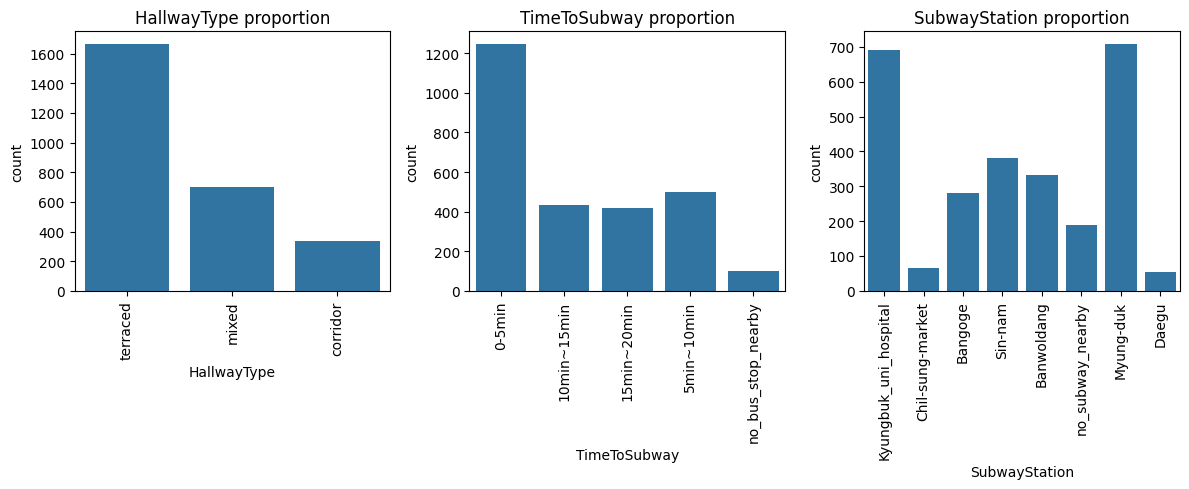

In [54]:
# plot proportion of each category value

plt.figure(figsize=(12, 5))
for i, var in enumerate(cat_vars):
    plt.subplot(1, 3, i+1)
    plt.title(f"{var} proportion")
    sns.countplot(data=df, x=var)
    plt.xticks(rotation=90)
    plt.tight_layout()

plt.savefig("assets/category_proportion.png")
plt.show()

## Multivariate

### Numerical Variables

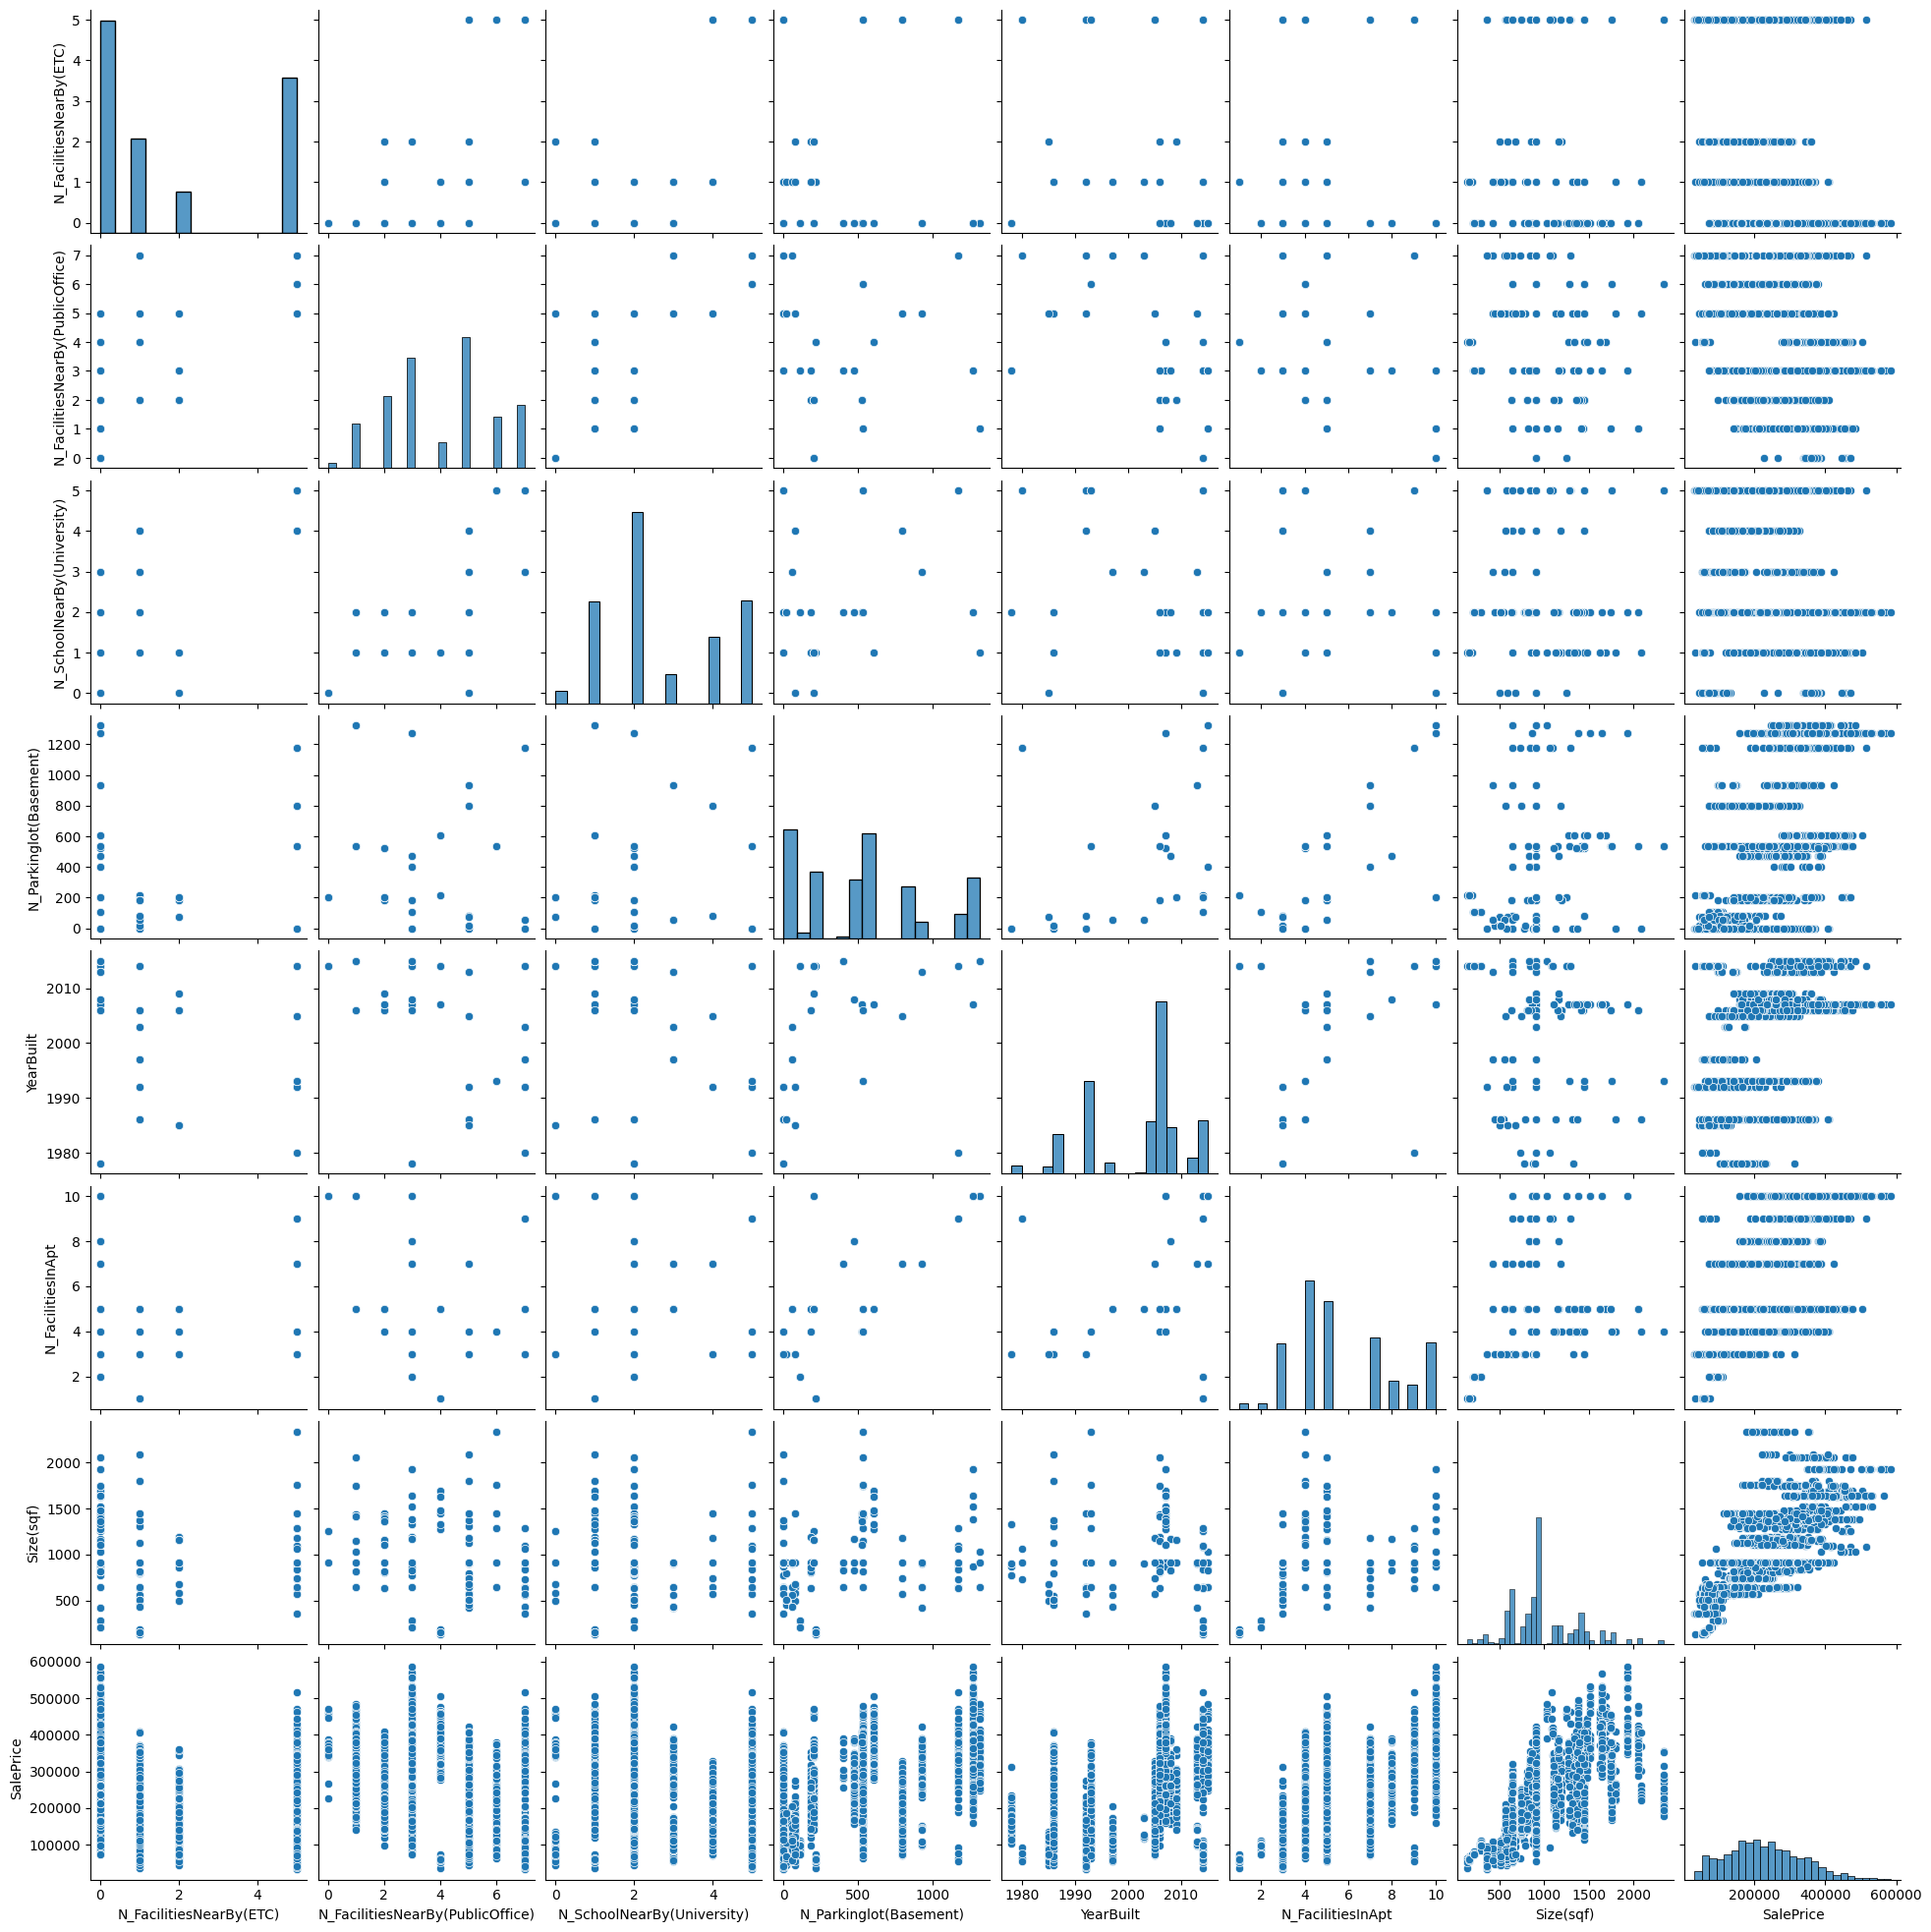

In [11]:
# pairplot to visualize correlation between variables

sns.pairplot(data=df[num_vars])
plt.show()

### Correlation

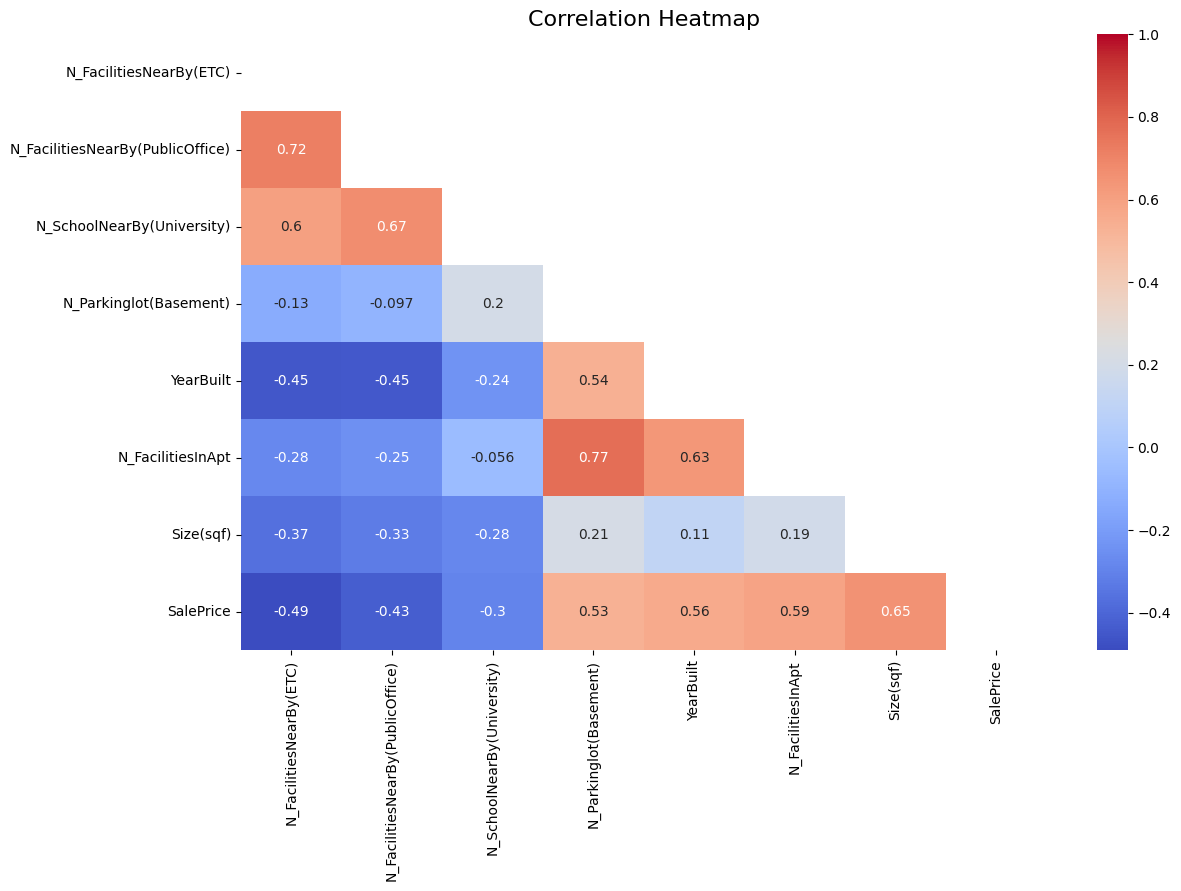

In [12]:
mask = np.zeros_like(df[num_vars].corr())
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize = (13, 8))
plt.title("Correlation Heatmap", size = 16)
sns.heatmap(df[num_vars].corr(method = "spearman"), cmap = "coolwarm", annot = True, mask = mask, vmax = 1)
plt.savefig("assets/correlation_heatmap.png")
plt.show()

### Categorical Variables

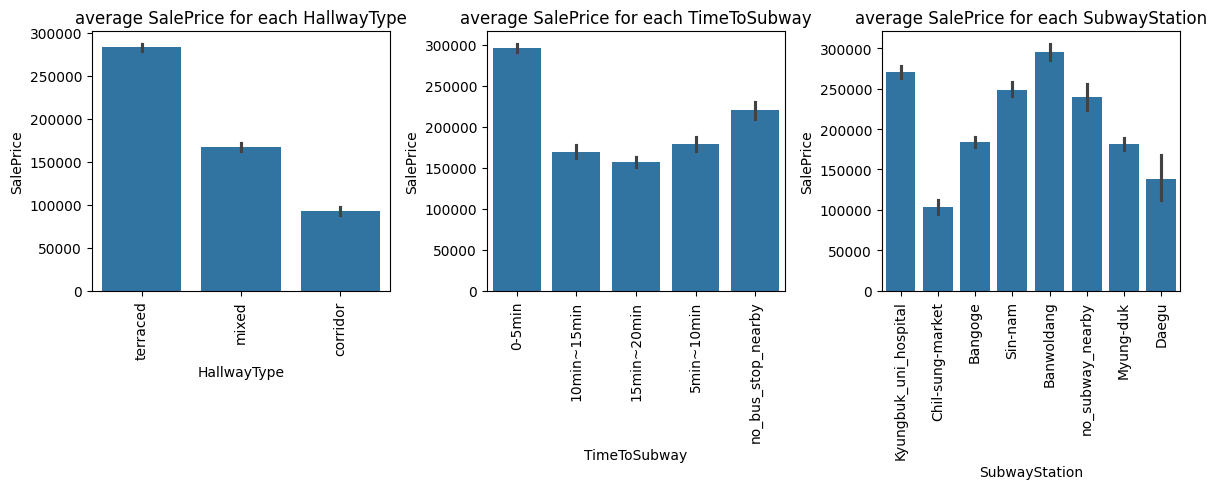

In [13]:
# visualize relation between categorical variables with target values

plt.figure(figsize=(12, 5))
for i, var in enumerate(cat_vars):
    plt.subplot(1, 3, i+1)
    plt.title(f"average SalePrice for each {var}")
    sns.barplot(data=df, x=var, y="SalePrice")
    plt.xticks(rotation=90)
    plt.tight_layout()

plt.savefig("assets/target_x_category.png")
plt.show()

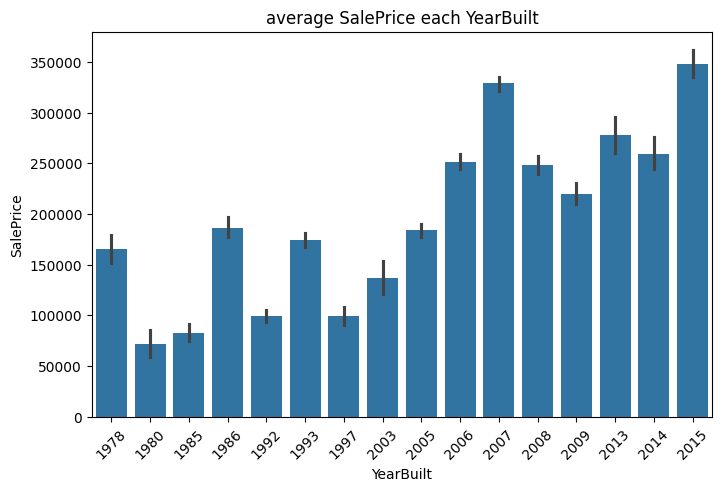

In [14]:
# Relation between YearBuilt dengan SalesPrice

plt.figure(figsize = (8, 5))
plt.title("average SalePrice each YearBuilt")
sns.barplot(data = df, x = "YearBuilt", y = "SalePrice")
plt.xticks(rotation = 45)
plt.show()

# Feature Engineering

## Binning Year

In [15]:
# set low interval for binning
lower_limit = [1978, 1982, 1988, 1992, 1998, 2002, 2007, 2013, 2018]

# name of each binning
year_bin = [
    "1978-1982",
    "1982-1988",
    "1988-1992",
    "1992-1998",
    "1998-2002",
    "2002-2007",
    "2007-2013",
    "2013-2018"
]

# get bin
pd.cut(df["YearBuilt"], bins=lower_limit, labels=year_bin, include_lowest=True)


0       2002-2007
1       1982-1988
2       1992-1998
3       2002-2007
4       2002-2007
          ...    
4116    2002-2007
4117    1992-1998
4118    2007-2013
4119    1992-1998
4121    1982-1988
Name: YearBuilt, Length: 2701, dtype: category
Categories (8, object): ['1978-1982' < '1982-1988' < '1988-1992' < '1992-1998' < '1998-2002' < '2002-2007' < '2007-2013' < '2013-2018']

## Cardinality

In [16]:
# get categorical variables to check cardinality
cat_vars = [i for i in df.columns if df[i].dtypes=="O" or df[i].dtypes=="category"]
cat_vars

['HallwayType', 'TimeToSubway', 'SubwayStation']

In [17]:
# check number of uniwue value each categorical
df[cat_vars].nunique()

HallwayType      3
TimeToSubway     5
SubwayStation    8
dtype: int64

In [18]:
# check percentage each value from categorical columns
# under 0.05% categorize as RareLabel

for col in cat_vars:
    print(f"unique of {col} :")
    print(df[col].value_counts(normalize=True))
    print()

unique of HallwayType :
HallwayType
terraced    0.617179
mixed       0.258423
corridor    0.124398
Name: proportion, dtype: float64

unique of TimeToSubway :
TimeToSubway
0-5min                0.462051
5min~10min            0.185487
10min~15min           0.160681
15min~20min           0.154757
no_bus_stop_nearby    0.037023
Name: proportion, dtype: float64

unique of SubwayStation :
SubwayStation
Myung-duk                0.262495
Kyungbuk_uni_hospital    0.256201
Sin-nam                  0.140689
Banwoldang               0.123288
Bangoge                  0.103665
no_subway_nearby         0.069604
Chil-sung-market         0.024065
Daegu                    0.019993
Name: proportion, dtype: float64



## Outlier Checking

In [19]:
def outlier_check(df, var):
    """
    function to check outlier in variables
    """
    
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 3, 1)
    plt.hist(data=df, x=var)
    plt.title(f"Histogram of {var}")

    plt.subplot(1, 3, 2)
    stats.probplot(df[var], dist="norm", plot=plt)
    plt.ylabel("RM Quantiles")
    
    plt.subplot(1, 3, 3)
    sns.boxplot(y = df[var])
    plt.title(f"Boxplot of {var}")

    plt.show()

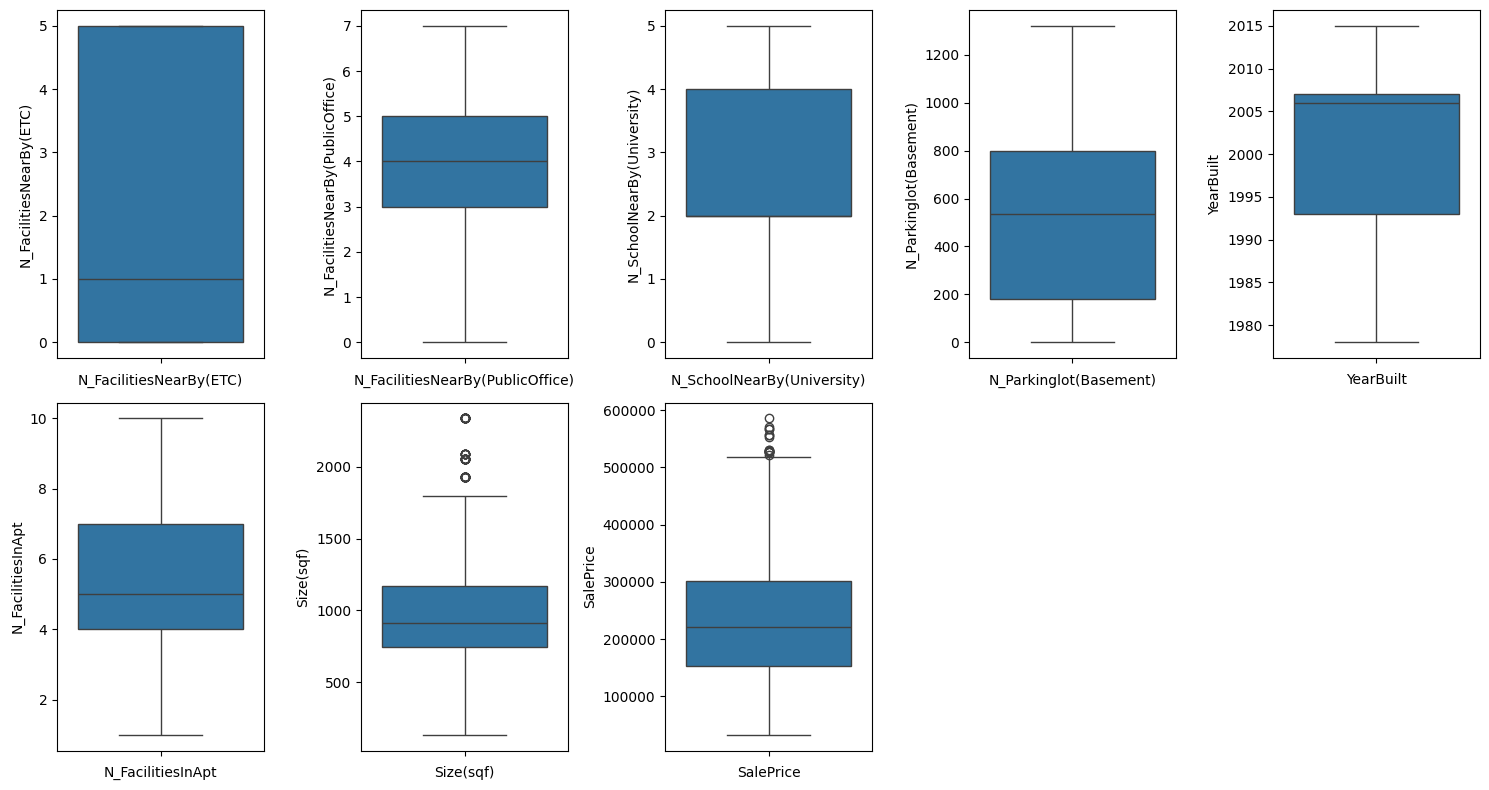

In [20]:
# check outlier value for each numerical

plt.figure(figsize=(15, 8))
for i, col in enumerate(num_vars):
    ax = plt.subplot(2, 5, i+1)
    sns.boxplot(y = df[col], ax = ax, orient = "v")
    plt.xlabel(col)
    plt.tight_layout()

### Size

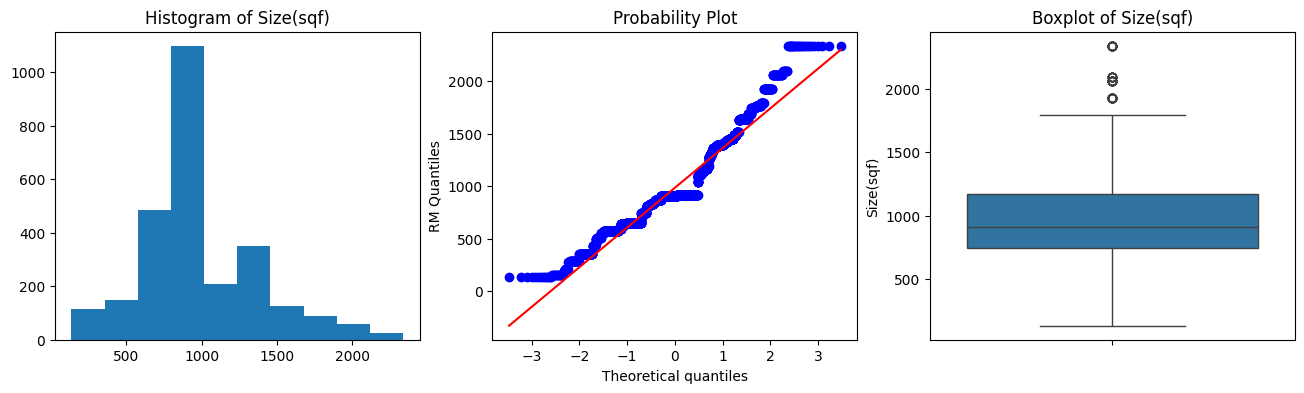

In [21]:
# visualize before transformation
outlier_check(df, "Size(sqf)")

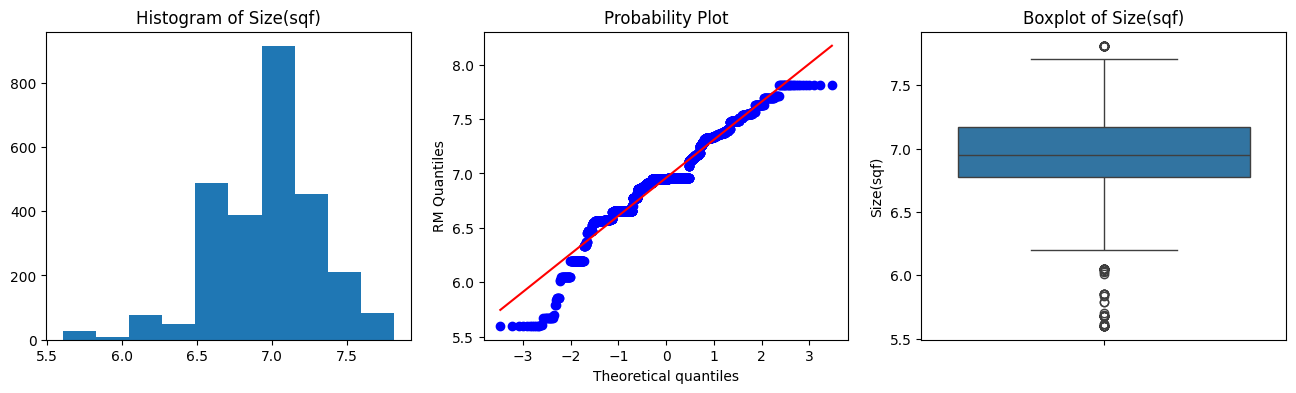

In [22]:
# try to transform value of size
# this step is to normalize distribution of data

lt = LogCpTransformer()     # define transformer
lt.fit(df[["Size(sqf)"]])   # fit in data
samp = lt.transform(df[["Size(sqf)"]])  # transform data

# visulaize
outlier_check(samp, "Size(sqf)")

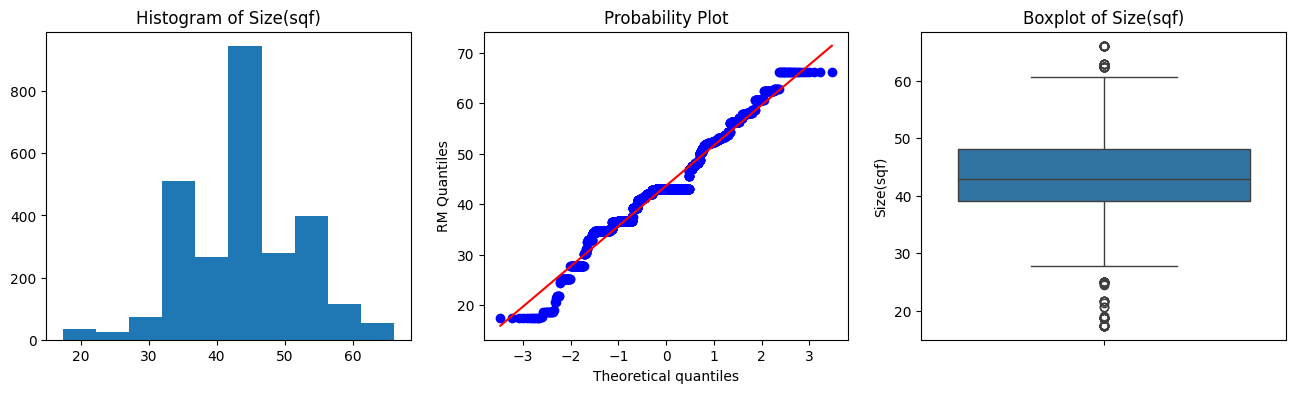

In [23]:
yjt = YeoJohnsonTransformer()   # define transformer
yjt.fit(df[["Size(sqf)"]])      # fit in data
samp = yjt.transform(df[["Size(sqf)"]]) # transform data

# visualize
outlier_check(samp, "Size(sqf)")

### SalePrice

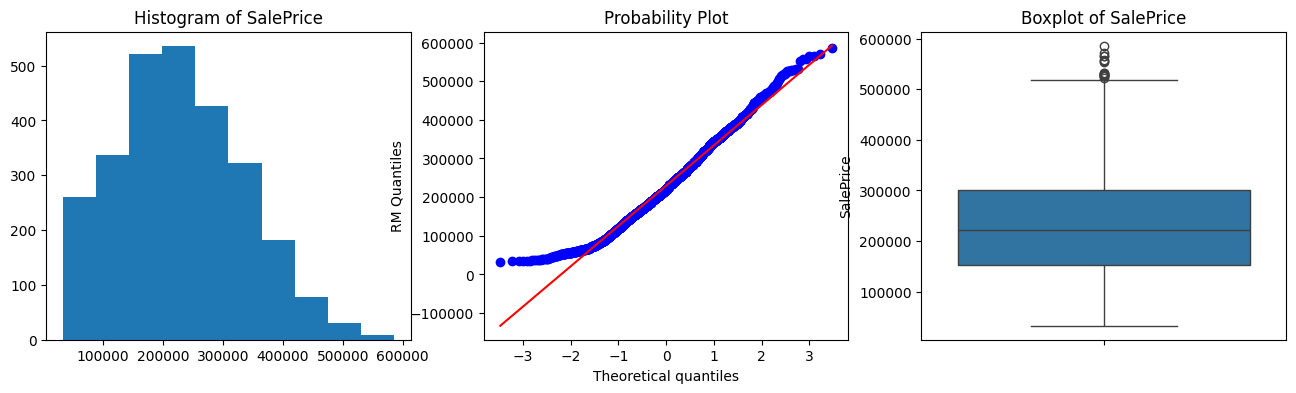

In [24]:
# visualize before transformation
outlier_check(df, "SalePrice")

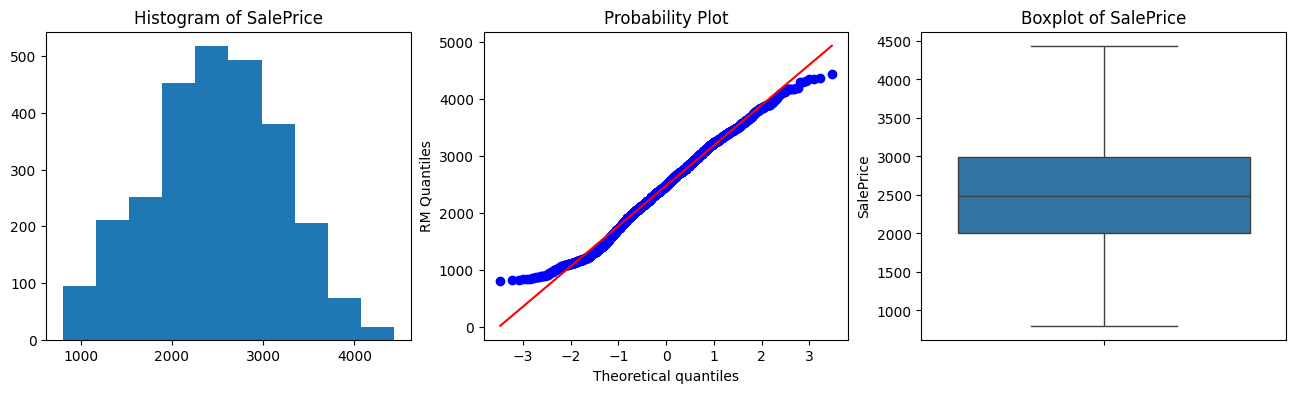

In [25]:
yjt = YeoJohnsonTransformer()   # define transformer
yjt.fit(df[["SalePrice"]])      # fit in data
samp = yjt.transform(df[["SalePrice"]]) # transform data

# visualize
outlier_check(samp, "SalePrice")

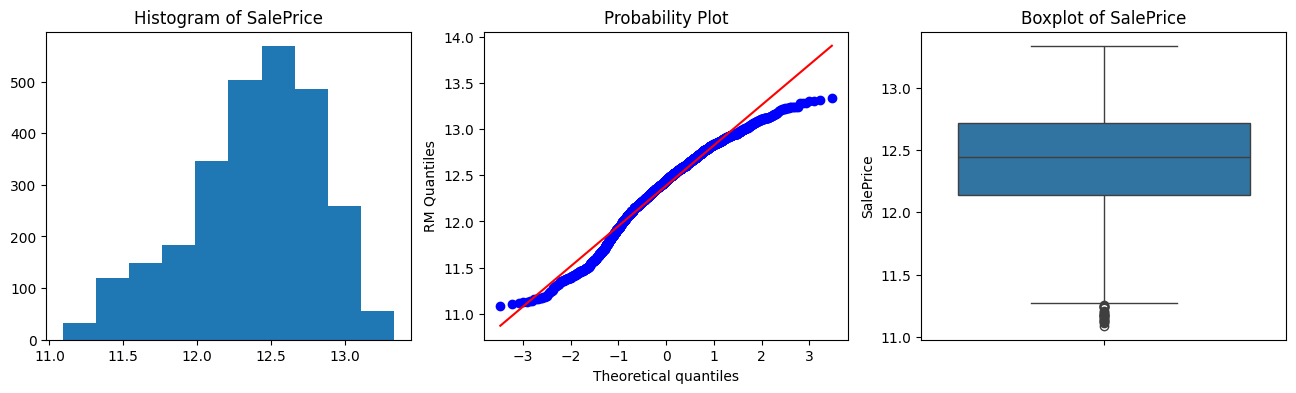

In [26]:
lt = LogCpTransformer()     # define transformer
lt.fit(df[["SalePrice"]])   # fit in data
samp = lt.transform(df[["SalePrice"]])  # transform data

# visualize
outlier_check(samp, "SalePrice")

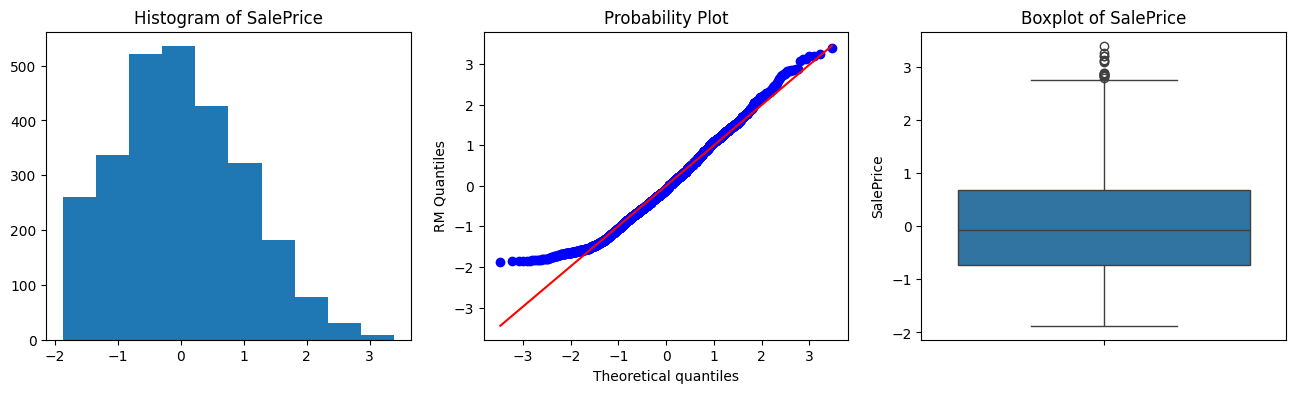

In [27]:
sc = StandardScaler()       # define transformer
sc.fit(df[["SalePrice"]])   # fit in data
sc.set_output(transform="pandas")       # set output to pandas, for readability
samp = sc.transform(df[["SalePrice"]])  # transform data

# visualize
outlier_check(samp, "SalePrice")

## Missing Value

In [28]:
# check missing value
df.isna().sum()

HallwayType                         0
TimeToSubway                        0
SubwayStation                       0
N_FacilitiesNearBy(ETC)             0
N_FacilitiesNearBy(PublicOffice)    0
N_SchoolNearBy(University)          0
N_Parkinglot(Basement)              0
YearBuilt                           0
N_FacilitiesInApt                   0
Size(sqf)                           0
SalePrice                           0
dtype: int64

# Modelling

## Data Splitting

In [29]:
# check shape of data
df.shape 

(2701, 11)

In [30]:
# split dataset

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns = ["SalePrice"]),
    df['SalePrice'],
    test_size = 0.2,
    random_state = 42
)

In [31]:
train_set = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
test_set = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

# save train and test set for using in production later
train_set.to_csv("datasets/train.csv", index=False, header=True)
test_set.to_csv("datasets/test.csv", index=False, header=True)

In [32]:
# transform target value
# this is for normality, see feature engineering section

y_train = np.log(y_train)
y_test = np.log(y_test)

In [33]:
X_train.shape, X_test.shape

((2160, 10), (541, 10))

## Pipeline Scenario

In [34]:
# CONFIGURATION

MINMAX_SCALING_VARS = [
    'N_FacilitiesNearBy(ETC)'
    , 'N_FacilitiesNearBy(PublicOffice)'
    , 'N_SchoolNearBy(University)'
    , 'N_Parkinglot(Basement)'
    , 'N_FacilitiesInApt'
]

STANDARD_SCALING_VARS = [
    'Size(sqf)'
]

ONE_HOT_VARS = [
    'HallwayType'
    , 'TimeToSubway'
    , 'SubwayStation'
    , 'YearBuilt'
]

BINNING_VARS = [
    'YearBuilt'
]

# DROP_FEATURES = [
#     'YearBuilt'
# ]

In [35]:
# preprocessor for min max scaling
minmax = SklearnTransformerWrapper(MinMaxScaler(), MINMAX_SCALING_VARS)

# preprocessor for standard scaling
standard = SklearnTransformerWrapper(StandardScaler(), STANDARD_SCALING_VARS)

pipe_one = Pipeline([
    # ("drop_features", DropFeatures(features_to_drop=DROP_FEATURES)),
    ("year_binning", pp.YearBinning(variables=BINNING_VARS)),
    ("minmax_scaling", minmax),
    ("standard_scaling", standard),
    ("rare_label_encoder", RareLabelEncoder(tol=0.05, n_categories=1, variables=ONE_HOT_VARS)),
    ("one_hot_encoder", OneHotEncoder(drop_last=True, variables=ONE_HOT_VARS)),   
])

# set output to pandas, for better readability
# pipe_one.set_output(transform="pandas")

In [36]:
# fit pipeline in training set only
pipe_one.fit(X_train)

# transform data with defined pipeline
X_train_preprocess = pipe_one.transform(X_train)
X_test_preprocess = pipe_one.transform(X_test)

## Benchmark Model

In [37]:
# Model Benchmark (use default parameter)

lr = LinearRegression()
lasso = Lasso()
ridge = Ridge()
knn = KNeighborsRegressor()
tree = DecisionTreeRegressor(random_state = 2022)
rf = RandomForestRegressor(random_state = 2022)
xgb = XGBRegressor(random_state = 2022)

In [38]:
def model_evaluation(model, metric):
  """
  train model with 5 fold cross validation
  """

  skfold = KFold(n_splits = 5, shuffle = True, random_state = 2022)
  model_cv = cross_val_score(model, X_train_preprocess, y_train, cv = skfold, scoring = metric)

  print("CrossValidation Result : ", model_cv)
  print("CrossValidation Average : ", model_cv.mean())
  print("CrossValidation Standard Deviation : ", model_cv.std())

In [39]:
model_evaluation(lr, "neg_root_mean_squared_error")

CrossValidation Result :  [-0.23857513 -0.27556744 -0.23971128 -0.25037326 -0.26848883]
CrossValidation Average :  -0.25454318749818905
CrossValidation Standard Deviation :  0.015025664049447952


In [40]:
model_evaluation(lasso, "neg_root_mean_squared_error")

CrossValidation Result :  [-0.53550362 -0.51598251 -0.54145844 -0.54510951 -0.56999518]
CrossValidation Average :  -0.5416098502184468
CrossValidation Standard Deviation :  0.01738990661846086


In [41]:
model_evaluation(ridge, "neg_root_mean_squared_error")

CrossValidation Result :  [-0.23828675 -0.27117923 -0.24088789 -0.2512974  -0.26598703]
CrossValidation Average :  -0.25352765947861805
CrossValidation Standard Deviation :  0.013144102443033283


In [42]:
model_evaluation(knn, "neg_root_mean_squared_error")

CrossValidation Result :  [-0.23264478 -0.24177025 -0.22628591 -0.24485453 -0.25061247]
CrossValidation Average :  -0.23923358800143452
CrossValidation Standard Deviation :  0.008701302773570653


In [43]:
model_evaluation(tree, "neg_root_mean_squared_error")

CrossValidation Result :  [-0.2200214  -0.21916525 -0.22310674 -0.22596081 -0.23552956]
CrossValidation Average :  -0.22475675186859095
CrossValidation Standard Deviation :  0.005897695823199442


In [44]:
model_evaluation(rf, "neg_root_mean_squared_error")

CrossValidation Result :  [-0.2181738  -0.22393586 -0.22300027 -0.2252285  -0.23462675]
CrossValidation Average :  -0.22499303487774389
CrossValidation Standard Deviation :  0.00537502670232483


In [45]:
model_evaluation(xgb, "neg_root_mean_squared_error")

CrossValidation Result :  [-0.21990846 -0.21574718 -0.22301653 -0.22589133 -0.23542054]
CrossValidation Average :  -0.22399681071889374
CrossValidation Standard Deviation :  0.006630575377300833


## Hyperparameter Tuning

**The best model based on the cross validation result above is: RandomForestRegressor**

In [46]:
# jumlah pohon pada random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]

# jumlah feature untuk setiap split
max_features = ['auto', 'sqrt']

# kedalaman pohon
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]

# Minimum sample split
min_samples_split = [2, 5, 10, 15, 100]

# Minimum sample leaf
min_samples_leaf = [1, 2, 5, 10]

# Hyperparam
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

In [47]:
crossval = KFold(n_splits = 5, shuffle = True, random_state = 2022)

random_rf = RandomizedSearchCV(
    RandomForestRegressor(), 
    param_distributions = random_grid, 
    cv = crossval, 
    n_iter = 50,
    n_jobs = -1
)

In [48]:
# Fitting Data untuk mencari score terbaik
random_rf.fit(X_train_preprocess, y_train)

# Cek skor dan params terbaik
print('Random Forest')
print('Best_score:', random_rf.best_score_)
print('Best_params:', random_rf.best_params_)

Random Forest
Best_score: 0.8280766186716733
Best_params: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}


In [49]:
y_pred_val = random_rf.predict(X_test_preprocess)

print('tabel error randomforest : ')
print('Mean Absolute Error      : ', mean_absolute_error(y_test, y_pred_val))
print('Mean Squared  Error      : ', mean_squared_error(y_test, y_pred_val))
print('Root Mean Squared  Error : ', np.sqrt(mean_squared_error(y_test, y_pred_val)))

tabel error randomforest : 
Mean Absolute Error      :  0.18331134624218137
Mean Squared  Error      :  0.05141245600328479
Root Mean Squared  Error :  0.22674314984864435


**Prediction with Choosen Model**

In [50]:
# model dengan hyperparameter terbaik
rf_tuned = random_rf.best_estimator_

# fiting model
rf_tuned.fit(X_train_preprocess, y_train)

# Predict
y_pred_tuned = rf_tuned.predict(X_test_preprocess)

print('tabel error randomforest tuned : ')
print('Mean Absolute Error      : ', mean_absolute_error(y_test, y_pred_tuned))
print('Mean Squared  Error      : ', mean_squared_error(y_test, y_pred_tuned))
print('Root Mean Squared  Error : ', np.sqrt(mean_squared_error(y_test, y_pred_tuned)))

tabel error randomforest tuned : 
Mean Absolute Error      :  0.18336053908760333
Mean Squared  Error      :  0.05148266279044576
Root Mean Squared  Error :  0.22689791270623394


**Performance Comparison**

In [51]:
# sebelum tuning
rf.fit(X_train_preprocess, y_train)
y_pred_before = rf.predict(X_test_preprocess)

print('tabel error randomforest sebelum tuning : ')
print('Mean Absolute Error      : ', mean_absolute_error(y_test, y_pred_before))
print('Mean Squared  Error      : ', mean_squared_error(y_test, y_pred_before))
print('Root Mean Squared  Error : ', np.sqrt(mean_squared_error(y_test, y_pred_before)))
print('Mean Absolute Percentage Error : ', mean_absolute_percentage_error(y_test, y_pred_before))

print()

print('tabel error randomforest sesudah tuning : ')
print('Mean Absolute Error      : ', mean_absolute_error(y_test, y_pred_tuned))
print('Mean Squared  Error      : ', mean_squared_error(y_test, y_pred_tuned))
print('Root Mean Squared  Error : ', np.sqrt(mean_squared_error(y_test, y_pred_tuned)))
print('Mean Absolute Percentage Error : ', mean_absolute_percentage_error(y_test, y_pred_tuned))

tabel error randomforest sebelum tuning : 
Mean Absolute Error      :  0.18345774864571143
Mean Squared  Error      :  0.051510734468848324
Root Mean Squared  Error :  0.22695976398658932
Mean Absolute Percentage Error :  0.015159459142503573

tabel error randomforest sesudah tuning : 
Mean Absolute Error      :  0.18336053908760333
Mean Squared  Error      :  0.05148266279044576
Root Mean Squared  Error :  0.22689791270623394
Mean Absolute Percentage Error :  0.015153987949097622


Text(0, 0.5, 'Predicted Price')

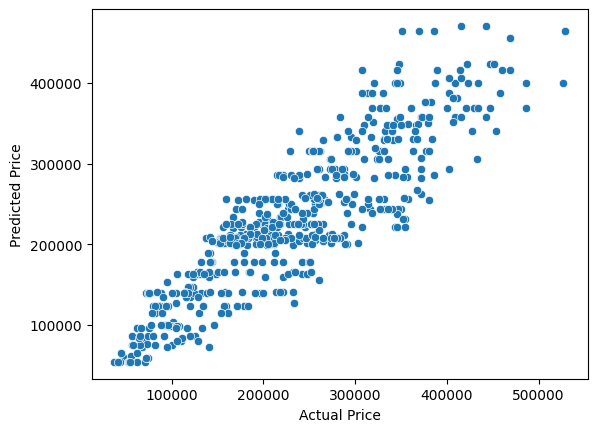

In [52]:
# visualize comparison between prediction and real value

sns.scatterplot(x = np.exp(y_test), y = np.exp(y_pred_tuned))
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")

**Feature Importance**

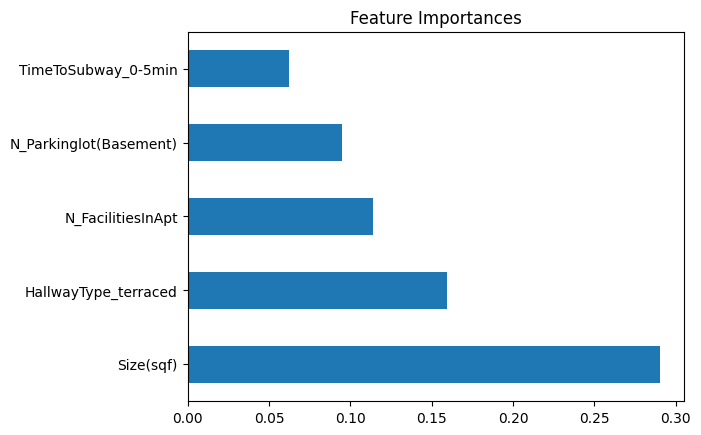

In [53]:
# Plot feature importances
feature_imp = pd.Series(
    rf_tuned.feature_importances_, 
    X_train_preprocess.columns
).sort_values(ascending = False).head()

feature_imp.plot(kind='barh', title='Feature Importances');

# Conclusion

- Based on the modeling that has been done, the features that most influence the selling price of the apartment in order are the size of the apartment, whether the type of entrance room of the apartment is a terrace, the number of facilities in the apartment, the number of parking spaces in the basement, and whether the time to the subway is fast or not.

- Considering the size of the MAPE (Mean Absolute Percentage Error) which is ~1.5%, we can conclude that the model we created when predicting prices for new data with the note that the range of values is the same as the training data values, then the average estimate will be off by approximately 1.5% from the actual price.